In [1]:
import numpy as np
import matplotlib.pyplot as plt

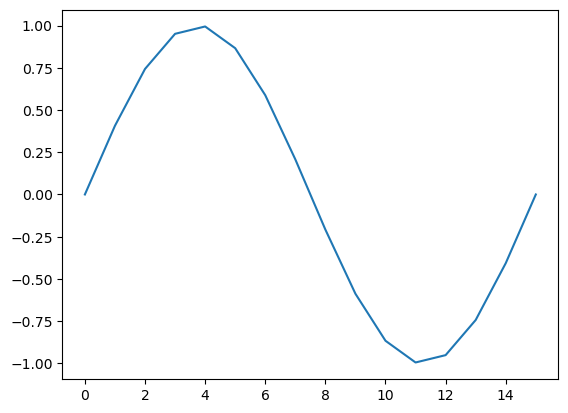

In [2]:
N = 16
t = np.arange(0,2*np.pi,2*np.pi/(N-1))
t = np.linspace(0,2*np.pi,N)
f = 1
s = np.cos(f*t)+1j*np.sin(f*t)
plt.plot(np.imag(s))

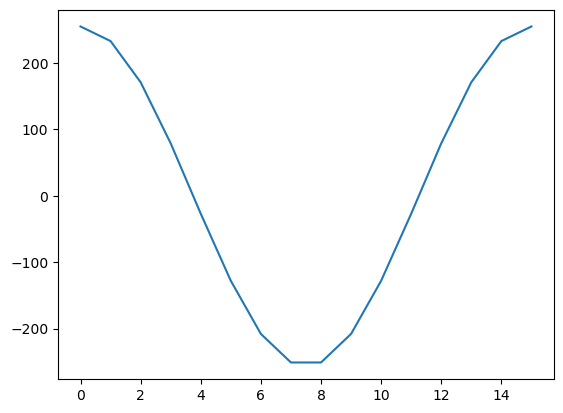

In [3]:
## floating to fixed point conversion
def floating_to_fixed(val,backoff):
    if val < 0:
        out = np.int16(val * 2**15)
    else:
        out = np.int16(val * (2**15 - 1))
    out = out >> backoff
    return out

s_fixed = np.zeros(N,dtype=np.complex64)
backoff = 7
for i in range(s.size):
    tmpOutr = floating_to_fixed(np.real(s[i]),backoff)
    tmpOuti = floating_to_fixed(np.imag(s[i]),backoff)
    s_fixed[i] = tmpOutr + 1j * tmpOuti

plt.plot(np.real(s_fixed))

In [4]:
index = np.arange(0,16,dtype=int)
def get_reversed_idx(index):
    N = index.size
    exp = np.emath.logn(4,N)
    num_bits = np.emath.logn(2,N)
    num_shifts = (int(exp) + 1) // 2
    max_shift = (int(exp)-1)*2
    reversed_index = np.zeros(N,dtype=int)
    for i in index:
        tmp = int(0)
        shift = max_shift
        for j in range(num_shifts):
            tmp = tmp | (((3<<(j*2))&i)<<shift) | (((3<<(max_shift-j*2))&i)>>shift)
            shift = shift - 4
        reversed_index[i] = tmp
    return reversed_index

reversed_index = get_reversed_idx(index)
print(index.shape)
print(reversed_index)

(16,)
[ 0  4  8 12  1  5  9 13  2  6 10 14  3  7 11 15]


In [7]:
## radix 4 DIT
def radix_4_core(x:np.ndarray[np.complex64], tw:np.ndarray[np.complex64]) -> np.ndarray[np.complex64]:
    out = np.zeros(x.size, dtype=np.complex64)
    for i in range(4):
        out[i] = np.dot(x, tw[:,i])
    return out


def get_complex_exp(k:float) -> complex:
    w = 2*np.pi*k
    out = np.cos(w) - 1j*np.sin(w)
    return out


def get_twiddle_matrix(stage, idx:np.ndarray[int]) -> np.ndarray[np.complex64]:
    out = np.zeros([4, 4], dtype=np.complex64)
    #assert idx.size == (4**stage), f"No of input points in stage: {stage} should be: {4**stage}"
    for i in range(4):
        for j in range(4):
            out[i][j] = get_complex_exp(idx[i]*j/(4**stage))
    return out


def radix_4_pre(x:np.ndarray[np.complex64]) -> np.ndarray[np.complex64]:
    N = x.size
    num_stages = int(np.emath.logn(4,N))
    index = np.arange(0,N,dtype=int)
    reversed_index = get_reversed_idx(index)
    stage_out = np.copy(x)
    print(x)
    
    for s in range(num_stages):
        num_butterflies_per_group = 4**s
        num_points_per_group = num_butterflies_per_group*4
        num_groups = N//num_points_per_group
        num_points_per_butt = 4

        for g in range(num_groups):
            for b in range(num_butterflies_per_group):
                i = (g+b)*num_points_per_butt
                chosen_idx = reversed_index[i:i+4]
                chosen_inpt = stage_out[chosen_idx]
                twiddle_mat = get_twiddle_matrix(s+1, chosen_idx)
                #print("s",s)
                #print(twiddle_mat)
                if s == 1:
                    out_idx = chosen_idx
                else:
                    out_idx = range(i,i+4)
                print("ip idx:",chosen_idx)
                #print("op idx:",out_idx)
                print("op idx:",chosen_inpt)
                stage_out[out_idx] = radix_4_core(chosen_inpt, twiddle_mat)

        if s==0:
            print(stage_out)

    return stage_out

def bit_reversed_order(x, N):
    """Reorder the input array to match Radix-4 bit-reversed order."""
    log4_N = int(np.log2(N) / 2)  # log4(N) for radix-4
    reordered = np.zeros(N, dtype=complex)
    for i in range(N):
        rev_index = int('{:04b}'.format(i)[::-1], 4)  # Bit-reversal in base-4
        s = '{:04b}'.format(i)
        rev_index = int(''.join([s[i:i+2] for i in range(0, len(s), 2)][::-1]),2)
        print(rev_index)
        reordered[i] = x[rev_index]
    return reordered

def radix4_fft16(x):
    """Computes a 16-point FFT using Radix-4 DIT"""
    N = len(x)
    assert N == 16, "This implementation is for 16-point FFT only."

    # Step 2: Compute four 4-point FFTs (first stage)
    X = np.zeros(N, dtype=complex)
    for i in range(4):
        sub_x = x[i*4:i*4+4]
        #print(sub_x)
        X[i*4]   = sub_x[0] + sub_x[1] + sub_x[2] + sub_x[3]
        W4 = np.exp(-1j * 2 * np.pi * 1 * np.arange(4) / 4)  # Twiddle factors for 4-point FFT
        X[i*4+1] = np.dot(sub_x, W4)
        W4 = np.exp(-1j * 2 * np.pi * 2 * np.arange(4) / 4)  # Twiddle factors for 4-point FFT
        X[i*4+2] = np.dot(sub_x, W4)
        W4 = np.exp(-1j * 2 * np.pi * 3 * np.arange(4) / 4)  # Twiddle factors for 4-point FFT
        X[i*4+3] = np.dot(sub_x, W4)

    #print(X)

    # Step 3: Apply twiddle factors and combine (second stage)
    X_final = np.zeros(16, dtype=complex)

    for k in range(4):
        X_final[k] = X[k] + X[k + 4] + X[k + 8] + X[k + 12]
        i = k + 4;
        W16 = np.exp(-1j * 2 * np.pi * i * np.arange(4) / 16)  # Twiddle factors for 16-point FFT
        X_final[i] = X[k]*W16[0] + X[k + 4]*W16[1] + X[k + 8]*W16[2] + X[k + 12]*W16[3]
        i = k + 8;
        W16 = np.exp(-1j * 2 * np.pi * i * np.arange(4) / 16)  # Twiddle factors for 16-point FFT
        X_final[k + 8] = X[k]*W16[0] + X[k + 4]*W16[1] + X[k + 8]*W16[2] + X[k + 12]*W16[3]
        i = k + 12;
        W16 = np.exp(-1j * 2 * np.pi * i * np.arange(4) / 16)  # Twiddle factors for 16-point FFT
        X_final[k + 12] = X[k]*W16[0] + X[k + 4]*W16[1] + X[k + 8]*W16[2] + X[k + 12]*W16[3]


    return X_final

def radix4_fft_pre(xin, N):
    # Step 1: Bit-reversed reordering
    x = bit_reversed_order(xin, N)
    y = radix4_fft16(x)
    return y

0
4
8
12
1
5
9
13
2
6
10
14
3
7
11
15


<StemContainer object of 3 artists>

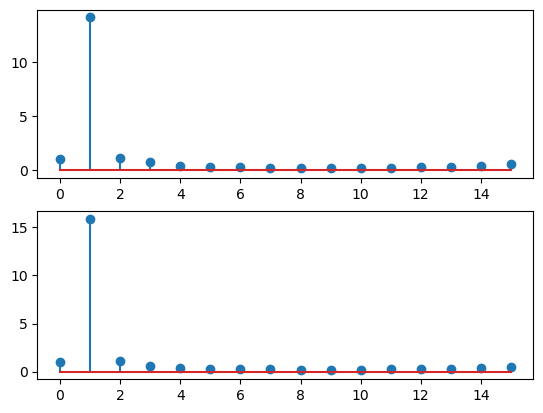

In [8]:
S = radix4_fft_pre(s, N)
#S = radix_4_pre(s)
plt.subplot(211)
plt.stem(np.abs(S))
plt.subplot(212)
plt.stem(np.abs(np.fft.fft(s)))